### 라이브러리 임포트

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torchsummary import summary

from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

### CSV 파일 불러오기

In [2]:
file_path = r"C:\Users\MinGi\Desktop\year3-sem1\인공지능개론\dataset\diabetes.csv"
df = pd.read_csv(file_path)

print(df.head())

   Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1  


### 레이블 개수 및 결측치 확인

In [3]:
print(df['Outcome'].value_counts(), "\n")
print(df.isnull().sum())

Outcome
0    500
1    268
Name: count, dtype: int64 

Pregnancies                 0
Glucose                     0
BloodPressure               0
SkinThickness               0
Insulin                     0
BMI                         0
DiabetesPedigreeFunction    0
Age                         0
Outcome                     0
dtype: int64


### 입력/정답 나누기

In [4]:
x = df.drop('Outcome', axis=1).values
y = df['Outcome'].values
x, y

(array([[  6.   , 148.   ,  72.   , ...,  33.6  ,   0.627,  50.   ],
        [  1.   ,  85.   ,  66.   , ...,  26.6  ,   0.351,  31.   ],
        [  8.   , 183.   ,  64.   , ...,  23.3  ,   0.672,  32.   ],
        ...,
        [  5.   , 121.   ,  72.   , ...,  26.2  ,   0.245,  30.   ],
        [  1.   , 126.   ,  60.   , ...,  30.1  ,   0.349,  47.   ],
        [  1.   ,  93.   ,  70.   , ...,  30.4  ,   0.315,  23.   ]]),
 array([1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0,
        1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0,
        1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1,
        1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1,
        1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 

### 전처리

In [5]:
scaler = StandardScaler()
x = scaler.fit_transform(x)

### 원-핫 인코딩

In [6]:
Y = pd.get_dummies(y).values

### 훈련/테스트 나누기

In [7]:
x_train, x_test, y_train, y_test = train_test_split(x, Y,test_size=0.25,random_state=0)

print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(576, 8) (576, 2)
(192, 8) (192, 2)


### Pytorch로 변경

In [8]:
x_train = torch.tensor(x_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.int64)
x_test = torch.tensor(x_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.int64)

### 데이터 로드 만들기

In [9]:
train_dataset = TensorDataset(x_train, y_train)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)

test_dataset = TensorDataset(x_test, y_test)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [10]:
x_train.shape, x_test.shape, y_train.shape, y_test.shape

(torch.Size([576, 8]),
 torch.Size([192, 8]),
 torch.Size([576, 2]),
 torch.Size([192, 2]))

### 모델 정의 

In [13]:
class DiabetesDense(nn.Module):
    def __init__(self):
        super(DiabetesDense, self).__init__()
        self.fc1 = nn.Linear(8, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, 2)  # 4 classes in the dataset
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Initialize the model, loss function, and optimizer
model = DiabetesDense()

### 손실함수 및 최적화함수 정의

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

### 모델 학습 및 예측

In [18]:
# Variables to store loss and accuracy
train_losses = []
test_accuracies = []

# Training loop
num_epochs = 8
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_dataloader:
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        if labels.ndim > 1:  # one-hot encoding일 경우
            labels = torch.argmax(labels, dim=1)
        else:
            labels = labels.long()

        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Calculate average loss over an epoch
    train_losses.append(running_loss / len(train_dataloader))

    # Evaluate on test data
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in test_dataloader:
            outputs = model(inputs)

            if labels.ndim > 1:  # one-hot encoding일 경우
                labels = torch.argmax(labels, dim=1)
            else:
                labels = labels.long()

            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    test_accuracies.append(accuracy)

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {train_losses[-1]:.4f}, Accuracy: {accuracy:.2f}%")

print("Training complete.")

Epoch 1/8, Loss: 0.5622, Accuracy: 78.12%
Epoch 2/8, Loss: 0.5041, Accuracy: 77.60%
Epoch 3/8, Loss: 0.4792, Accuracy: 78.12%
Epoch 4/8, Loss: 0.4692, Accuracy: 79.17%
Epoch 5/8, Loss: 0.4653, Accuracy: 79.17%
Epoch 6/8, Loss: 0.4574, Accuracy: 79.17%
Epoch 7/8, Loss: 0.4552, Accuracy: 79.17%
Epoch 8/8, Loss: 0.4513, Accuracy: 79.69%
Training complete.


### 모델 평가

In [21]:
# Evaluation
model.eval()
all_labels = []
all_predictions = []
with torch.no_grad():
    for inputs, labels in test_dataloader:
        outputs = model(inputs)
        if labels.ndim > 1:
            labels = torch.argmax(labels, dim=1)
        else:
            labels = labels.long()

        _, predicted = torch.max(outputs.data, 1)
        all_labels.extend(labels.cpu().numpy())
        all_predictions.extend(predicted.cpu().numpy())

# Convert to numpy arrays
all_labels = np.array(all_labels)
all_predictions = np.array(all_predictions)

# Calculate metrics
conf_matrix = confusion_matrix(all_labels, all_predictions)
f1 = f1_score(all_labels, all_predictions, average='weighted')
precision = precision_score(all_labels, all_predictions, average='weighted')
recall = recall_score(all_labels, all_predictions, average='weighted')

# Calculate specificity for each class
specificity = []
for i in range(conf_matrix.shape[0]):
    tn = conf_matrix.sum() - (conf_matrix[i, :].sum() + conf_matrix[:, i].sum() - conf_matrix[i, i])
    fp = conf_matrix[:, i].sum() - conf_matrix[i, i]
    specificity.append(tn / (tn + fp))

print(f'Confusion Matrix:\n{conf_matrix}')
print(f'F1 Score: {f1:.2f}')
print(f'Precision: {precision:.2f}')
print(f'Recall: {recall:.2f}')
print(f'Specificity: {np.mean(specificity):.2f}')

Confusion Matrix:
[[116  14]
 [ 25  37]]
F1 Score: 0.79
Precision: 0.79
Recall: 0.80
Specificity: 0.74


### 손실과 정확도 시각화

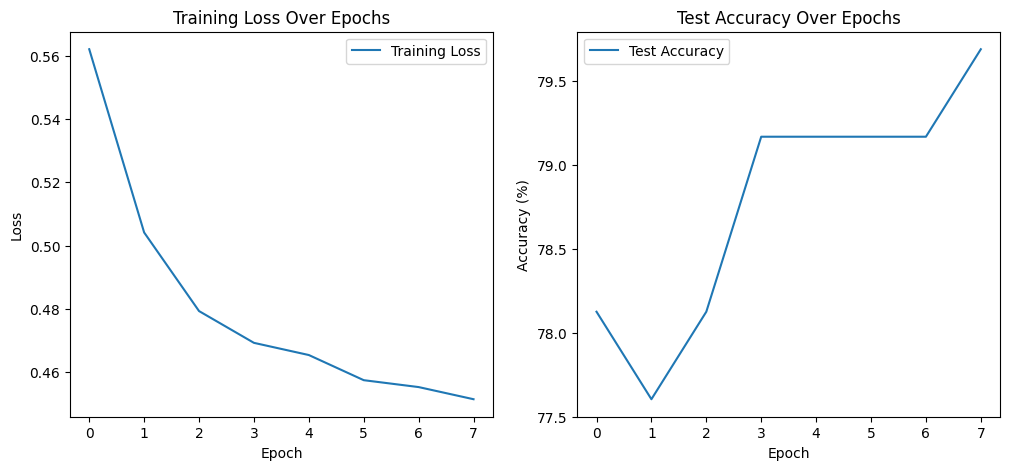

In [22]:
# Plot the loss and accuracy
plt.figure(figsize=(12, 5))

# Plot loss
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()

# Plot accuracy
plt.subplot(1, 2, 2)
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Test Accuracy Over Epochs')
plt.legend()

plt.show()